##### <h1> GAN comparison on Kaggle Credit Card Fraud Data </h1><br>
Cody Nash<br>
Development Notebook
<hr>

This notebook accompanies the Toptal blog found <a href='https://www.toptal.com/machine-learning/generative-adversarial-networks'>here</a>.<br>
<hr>


<a id="TOC"></a><h2>Table of Contents</h2>
<br>
<a href='#Setup'> Setup</a><br>
<br>
<a href='#EDA'> Exploratory Data Analysis (EDA)</a><br>
<a href='#xgboost fraud detection'> xgboost fraud detection</a><br>
<a href='#Classification'> Classification of fraud data</a><br>
<br>
<a href="#GAN setup"> GAN setup and training</a><br>
<br>
<a href="#Compare GAN Output"> Compare GAN Output</a><br>
<a href="#Generated Data Testing"> Generated Data Testing</a><br>
<a href="#Summary"> Summary of Training Data</a><br>
<br>
<a href="#DRAGAN"> DRAGAN testing</a><br>
<br>
<h3>Blog Figures:</h3>
<br>
<a href="#Fig3"> Figure 3: Data Distributions by Feature and Class</a><br>
<a href="#Fig5"> Figure 5: Comparison of GAN Outputs</a><br>
<a href="#Fig6"> Figure 6: Accuracy of Generated Data Detection</a><br>
<a href="#Fig7"> Figure 7: Differences in Critic Loss</a><br>
<a href="#Fig8"> Figure 8: Effects of Additional Data</a><br>

<a id="Setup"><h1>Setup</h1></a>

<a href='#TOC'>Table of contents</a>
<br><br>

- Load libraries
- Load common functions
- Load stored datasets
- Use linux for xgboost and tensorflow

In [1]:
!pip install xgboost

twisted 18.7.0 requires PyHamcrest>=1.9.0, which is not installed.
You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [3]:
!python -m pip install --upgrade pip

  Found existing installation: pip 10.0.1
    Uninstalling pip-10.0.1:
      Successfully uninstalled pip-10.0.1


twisted 18.7.0 requires PyHamcrest>=1.9.0, which is not installed.


In [4]:

# Load libraries and check memory

import psutil ; print(list(psutil.virtual_memory())[0:2])

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import xgboost as xgb

import pickle

import gc
gc.collect()
print(list(psutil.virtual_memory())[0:2])

[8429707264, 1834700800]
[8429707264, 1834340352]


In [5]:

# Load custom functions

import GAN_171103

# For reloading after making changes
import importlib
importlib.reload(GAN_171103) 
from GAN_171103 import *


ModuleNotFoundError: No module named 'keras'

In [5]:
train=pd.read_csv('train.csv',sep='|')
test=pd.read_csv('test.csv',sep='|')

In [6]:
print(train.fraud.value_counts())
print(train.fraud.value_counts() / len(train))

0    1775
1     104
Name: fraud, dtype: int64
0    0.944651
1    0.055349
Name: fraud, dtype: float64


In [7]:
# for training set

train['scannedLineItems'] = train['scannedLineItemsPerSecond'] * train['totalScanTimeInSeconds']
train['pricePerScannedLineItem'] = train['grandTotal'] / train['scannedLineItems']
train['scansWithoutRegistrationPerScannedLineItem'] = train['scansWithoutRegistration'] / train['scannedLineItems']
train['quantityModificationsPerScannedLineItem'] = train['quantityModifications'] / train['scannedLineItems']
train['lineItemVoidsPerSecond'] = train['lineItemVoids'] / train['totalScanTimeInSeconds']
train['scansWithoutRegistrationPerSecond'] = train['scansWithoutRegistration'] / train['totalScanTimeInSeconds']
train['quantityModificationsPerSecond'] = train['quantityModifications'] / train['totalScanTimeInSeconds']
train['secondsPerEuro'] = train['totalScanTimeInSeconds'] / train['grandTotal']
train['lineItemVoidsPerEuro'] = train['lineItemVoids'] / train['grandTotal']
train['scansWithoutRegistrationPerEuro'] = train['scansWithoutRegistration'] / train['grandTotal']
train['quantityModificationsPerEuro'] = train['quantityModifications'] / train['grandTotal']


# for test set

test['scannedLineItems'] = test['scannedLineItemsPerSecond'] * test['totalScanTimeInSeconds']
test['pricePerScannedLineItem'] = test['grandTotal'] / test['scannedLineItems']
test['scansWithoutRegistrationPerScannedLineItem'] = test['scansWithoutRegistration'] / test['scannedLineItems']
test['quantityModificationsPerScannedLineItem'] = test['quantityModifications'] / test['scannedLineItems']
test['lineItemVoidsPerSecond'] = test['lineItemVoids'] / test['totalScanTimeInSeconds']
test['scansWithoutRegistrationPerSecond'] = test['scansWithoutRegistration'] / test['totalScanTimeInSeconds']
test['quantityModificationsPerSecond'] = test['quantityModifications'] / test['totalScanTimeInSeconds']
test['secondsPerEuro'] = test['totalScanTimeInSeconds'] / test['grandTotal']
test['lineItemVoidsPerEuro'] = test['lineItemVoids'] / test['grandTotal']
test['scansWithoutRegistrationPerEuro'] = test['scansWithoutRegistration'] / test['grandTotal']
test['quantityModificationsPerEuro'] = test['quantityModifications'] / test['grandTotal']

In [8]:
test.describe()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,scannedLineItems,pricePerScannedLineItem,scansWithoutRegistrationPerScannedLineItem,quantityModificationsPerScannedLineItem,lineItemVoidsPerSecond,scansWithoutRegistrationPerSecond,quantityModificationsPerSecond,secondsPerEuro,lineItemVoidsPerEuro,scansWithoutRegistrationPerEuro,quantityModificationsPerEuro
count,498121.000000,498121.000000,498121.000000,498121.000000,498121.000000,498121.000000,498121.000000,498121.000000,498121.000000,498121.000000,498121.000000,498121.000000,498121.000000,498121.000000,498121.000000,498121.000000,4.981210e+05,4.981080e+05,4.981150e+05,4.981070e+05
mean,3.503257,915.608772,49.988990,5.495926,5.001281,2.499015,0.068054,0.222182,0.735190,15.486673,6.693747,0.669799,0.336203,0.024370,0.021893,0.010991,inf,inf,inf,inf
std,1.707662,528.772880,28.873426,3.447683,3.163795,1.708182,0.521092,1.717867,1.320235,8.667297,11.680538,1.208735,0.627875,0.193313,0.171088,0.088685,NaN,NaN,NaN,NaN
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000546,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.002908e-02,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.000000,458.000000,24.930000,3.000000,2.000000,1.000000,0.008682,0.027348,0.160000,8.000000,1.611200,0.142857,0.062500,0.002735,0.002431,0.001082,9.166667e+00,5.006258e-02,4.447409e-02,1.990446e-02
50%,4.000000,916.000000,50.030000,5.000000,5.000000,2.000000,0.016940,0.054550,0.352941,15.000000,3.224706,0.333333,0.160000,0.006002,0.005474,0.002729,1.833183e+01,1.099959e-01,1.002339e-01,5.002501e-02
75%,5.000000,1374.000000,75.020000,8.000000,8.000000,4.000000,0.033929,0.109091,0.692308,23.000000,6.272500,0.636364,0.333333,0.012000,0.010959,0.005464,3.656578e+01,2.198608e-01,2.002002e-01,9.996002e-02
max,6.000000,1831.000000,99.990000,11.000000,10.000000,5.000000,30.000000,99.710000,11.000000,30.000000,99.990000,10.000000,5.000000,11.000000,10.000000,5.000000,inf,inf,inf,inf


In [9]:
# Imputation of NaN and Infinity values
test.loc[test['grandTotal'] == 0.00, 'secondsPerEuro'] = test['totalScanTimeInSeconds'] / 0.01
test.loc[test['grandTotal'] == 0.00, 'lineItemVoidsPerEuro'] = test['lineItemVoids'] / 0.01
test.loc[test['grandTotal'] == 0.00, 'scansWithoutRegistrationPerEuro'] = test['scansWithoutRegistration'] / 0.01
test.loc[test['grandTotal'] == 0.00, 'quantityModificationsPerEuro'] = test['quantityModifications'] / 0.01

In [10]:
test.describe()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,scannedLineItems,pricePerScannedLineItem,scansWithoutRegistrationPerScannedLineItem,quantityModificationsPerScannedLineItem,lineItemVoidsPerSecond,scansWithoutRegistrationPerSecond,quantityModificationsPerSecond,secondsPerEuro,lineItemVoidsPerEuro,scansWithoutRegistrationPerEuro,quantityModificationsPerEuro
count,498121.000000,498121.000000,498121.000000,498121.000000,498121.000000,498121.000000,498121.000000,498121.000000,498121.000000,498121.000000,498121.000000,498121.000000,498121.000000,498121.000000,498121.000000,498121.000000,498121.000000,498121.000000,498121.000000,498121.000000
mean,3.503257,915.608772,49.988990,5.495926,5.001281,2.499015,0.068054,0.222182,0.735190,15.486673,6.693747,0.669799,0.336203,0.024370,0.021893,0.010991,104.620508,0.637226,0.557118,0.282206
std,1.707662,528.772880,28.873426,3.447683,3.163795,1.708182,0.521092,1.717867,1.320235,8.667297,11.680538,1.208735,0.627875,0.193313,0.171088,0.088685,1866.157715,11.922663,9.897615,5.063211
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000546,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010029,0.000000,0.000000,0.000000
25%,2.000000,458.000000,24.930000,3.000000,2.000000,1.000000,0.008682,0.027348,0.160000,8.000000,1.611200,0.142857,0.062500,0.002735,0.002431,0.001082,9.166667,0.050058,0.044474,0.019897
50%,4.000000,916.000000,50.030000,5.000000,5.000000,2.000000,0.016940,0.054550,0.352941,15.000000,3.224706,0.333333,0.160000,0.006002,0.005474,0.002729,18.331833,0.109987,0.100231,0.050025
75%,5.000000,1374.000000,75.020000,8.000000,8.000000,4.000000,0.033929,0.109091,0.692308,23.000000,6.272500,0.636364,0.333333,0.012000,0.010959,0.005464,36.565781,0.219841,0.200200,0.099960
max,6.000000,1831.000000,99.990000,11.000000,10.000000,5.000000,30.000000,99.710000,11.000000,30.000000,99.990000,10.000000,5.000000,11.000000,10.000000,5.000000,183100.000000,1100.000000,1000.000000,500.000000


In [11]:
data = pd.concat([train, test], ignore_index=True, sort=False)
data.describe()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud,...,pricePerScannedLineItem,scansWithoutRegistrationPerScannedLineItem,quantityModificationsPerScannedLineItem,lineItemVoidsPerSecond,scansWithoutRegistrationPerSecond,quantityModificationsPerSecond,secondsPerEuro,lineItemVoidsPerEuro,scansWithoutRegistrationPerEuro,quantityModificationsPerEuro
count,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,1879.000000,...,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000
mean,3.502876,915.670946,49.992280,5.495828,5.000916,2.499114,0.068017,0.222105,0.735228,0.055349,...,6.695151,0.669841,0.336286,0.024363,0.021887,0.010989,104.803954,0.638789,0.558128,0.281835
std,1.707678,528.778479,28.873697,3.447693,3.163707,1.708134,0.520393,1.716325,1.320260,0.228720,...,11.682537,1.208721,0.628036,0.193121,0.170972,0.088604,1874.806633,11.990745,9.946764,5.054765
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000546,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010029,0.000000,0.000000,0.000000
25%,2.000000,458.000000,24.930000,3.000000,2.000000,1.000000,0.008681,0.027349,0.160000,0.000000,...,1.611538,0.142857,0.062500,0.002735,0.002430,0.001082,9.167090,0.050055,0.044464,0.019900
50%,4.000000,916.000000,50.040000,5.000000,5.000000,2.000000,0.016939,0.054549,0.352941,0.000000,...,3.225000,0.333333,0.160000,0.006002,0.005473,0.002729,18.331998,0.109971,0.100220,0.050025
75%,5.000000,1374.000000,75.020000,8.000000,8.000000,4.000000,0.033923,0.109086,0.692308,0.000000,...,6.273333,0.636364,0.333333,0.012000,0.010959,0.005464,36.563908,0.219824,0.200178,0.099960
max,6.000000,1831.000000,99.990000,11.000000,10.000000,5.000000,30.000000,99.710000,11.000000,1.000000,...,99.990000,10.000000,5.000000,11.000000,10.000000,5.000000,183100.000000,1100.000000,1000.000000,500.000000


In [12]:

# Load engineered dataset from EDA section

#data = pickle.load(open('data/' + 'credicard.engineered.pkl','rb')) #not relevant for our implementation yet

# data columns will be all other columns except class
data_cols = list(data.columns[ data.columns != 'fraud' ])
label_cols = ['fraud']

print(data_cols)
print('# of data columns: ',len(data_cols))


['trustLevel', 'totalScanTimeInSeconds', 'grandTotal', 'lineItemVoids', 'scansWithoutRegistration', 'quantityModifications', 'scannedLineItemsPerSecond', 'valuePerSecond', 'lineItemVoidsPerPosition', 'scannedLineItems', 'pricePerScannedLineItem', 'scansWithoutRegistrationPerScannedLineItem', 'quantityModificationsPerScannedLineItem', 'lineItemVoidsPerSecond', 'scansWithoutRegistrationPerSecond', 'quantityModificationsPerSecond', 'secondsPerEuro', 'lineItemVoidsPerEuro', 'scansWithoutRegistrationPerEuro', 'quantityModificationsPerEuro']
# of data columns:  20


In [13]:

# Put columns in order of importance for xgboost fraud detection (from that section)

# sorted_cols = ['V14', 'V4', 'V12', 'V10', 'V26', 'V17', 'Amount', 'V7', 'V21', 'V28', 'V20', 'V3', 'V18', 'V8', 'V13', 'V22', 'V16', 'V11', 'V19', 'V27', 'V5', 'V6', 'V25', 'V15', 'V24', 'V9', 'V1', 'V2', 'V23', 'Class']
# sorted_cols = ['V14', 'V4', 'V12', 'V10', 'Amount', 'V26', 'V17', 'Time', 'V7', 'V28', 'V21', 'V19', 'V8', 'V3', 'V22', 'V20', 'V25', 'V11', 'V6', 'V16', 'V27', 'V5', 'V18', 'V9', 'V1', 'V2', 'V15', 'V23', 'V24', 'V13', 'Class']
sorted_cols = ['trustLevel', 'totalScanTimeInSeconds', 'grandTotal', 'lineItemVoids', 'scansWithoutRegistration', 'quantityModifications', 'scannedLineItemsPerSecond', 'valuePerSecond', 'lineItemVoidsPerPosition', 'scannedLineItems', 'pricePerScannedLineItem', 'scansWithoutRegistrationPerScannedLineItem', 'quantityModificationsPerScannedLineItem', 'lineItemVoidsPerSecond', 'scansWithoutRegistrationPerSecond', 'quantityModificationsPerSecond', 'secondsPerEuro', 'lineItemVoidsPerEuro', 'scansWithoutRegistrationPerEuro', 'quantityModificationsPerEuro', 'fraud']

data = data[ sorted_cols ].copy()


In [14]:

# Add KMeans generated classes to fraud data - see classification section for more details on this

import sklearn.cluster as cluster

train = data.loc[ data['fraud']==1 ].copy()

algorithm = cluster.KMeans
args, kwds = (), {'n_clusters':2, 'random_state':0}
labels = algorithm(*args, **kwds).fit_predict(train[ data_cols ])

print( pd.DataFrame( [ [np.sum(labels==i)] for i in np.unique(labels) ], columns=['count'], index=np.unique(labels) ) )

fraud_w_classes = train.copy()
fraud_w_classes['fraud'] = labels


   count
0     58
1     46


<a id="EDA"><h1>Exploratory Data Analysis (EDA)</h1></a>

<a href='#TOC'>Table of contents</a>
<br><br>

In [16]:

# Load the credit card data

# Original data available from:
# https://www.kaggle.com/dalpozz/creditcardfraud

#data = pd.read_csv("data/creditcard.csv.zip")
print(data.shape)
print(data.columns)
data.head(5)

(500000, 21)
Index(['trustLevel', 'totalScanTimeInSeconds', 'grandTotal', 'lineItemVoids',
       'scansWithoutRegistration', 'quantityModifications',
       'scannedLineItemsPerSecond', 'valuePerSecond',
       'lineItemVoidsPerPosition', 'scannedLineItems',
       'pricePerScannedLineItem', 'scansWithoutRegistrationPerScannedLineItem',
       'quantityModificationsPerScannedLineItem', 'lineItemVoidsPerSecond',
       'scansWithoutRegistrationPerSecond', 'quantityModificationsPerSecond',
       'secondsPerEuro', 'lineItemVoidsPerEuro',
       'scansWithoutRegistrationPerEuro', 'quantityModificationsPerEuro',
       'fraud'],
      dtype='object')


,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,scannedLineItems,...,scansWithoutRegistrationPerScannedLineItem,quantityModificationsPerScannedLineItem,lineItemVoidsPerSecond,scansWithoutRegistrationPerSecond,quantityModificationsPerSecond,secondsPerEuro,lineItemVoidsPerEuro,scansWithoutRegistrationPerEuro,quantityModificationsPerEuro,fraud
0,5,1054,54.70,7,0,3,0.027514,0.051898,0.241379,29.0,...,0.000000,0.103448,0.006641,0.000000,0.002846,19.268739,0.127971,0.000000,0.054845,0.0
1,3,108,27.36,5,2,4,0.129630,0.253333,0.357143,14.0,...,0.142857,0.285714,0.046296,0.018519,0.037037,3.947368,0.182749,0.073099,0.146199,0.0
2,3,1516,62.16,3,10,5,0.008575,0.041003,0.230769,13.0,...,0.769231,0.384615,0.001979,0.006596,0.003298,24.388674,0.048263,0.160875,0.080438,0.0
3,6,1791,92.31,8,4,4,0.016192,0.051541,0.275862,29.0,...,0.137931,0.137931,0.004467,0.002233,0.002233,19.402015,0.086665,0.043332,0.043332,0.0
4,5,430,81.53,3,7,2,0.062791,0.189605,0.111111,27.0,...,0.259259,0.074074,0.006977,0.016279,0.004651,5.274132,0.036796,0.085858,0.024531,0.0


In [17]:

# data columns will be all other columns except fraud

label_cols = ['fraud']
data_cols = list(data.columns[ data.columns != 'fraud' ])

print(data_cols)
print('# of data columns: ',len(data_cols))


['trustLevel', 'totalScanTimeInSeconds', 'grandTotal', 'lineItemVoids', 'scansWithoutRegistration', 'quantityModifications', 'scannedLineItemsPerSecond', 'valuePerSecond', 'lineItemVoidsPerPosition', 'scannedLineItems', 'pricePerScannedLineItem', 'scansWithoutRegistrationPerScannedLineItem', 'quantityModificationsPerScannedLineItem', 'lineItemVoidsPerSecond', 'scansWithoutRegistrationPerSecond', 'quantityModificationsPerSecond', 'secondsPerEuro', 'lineItemVoidsPerEuro', 'scansWithoutRegistrationPerEuro', 'quantityModificationsPerEuro']
# of data columns:  20


In [18]:

# 1775 normal transactions (class 0)
# 104 fraud transactions (class 1)

data.groupby('fraud')['fraud'].count()


fraud
0.0    1775
1.0     104
Name: fraud, dtype: int64

In [19]:

# Total nulls in dataset (sum over rows, then over columns)

data.isnull().sum()

trustLevel                                         0
totalScanTimeInSeconds                             0
grandTotal                                         0
lineItemVoids                                      0
scansWithoutRegistration                           0
quantityModifications                              0
scannedLineItemsPerSecond                          0
valuePerSecond                                     0
lineItemVoidsPerPosition                           0
scannedLineItems                                   0
pricePerScannedLineItem                            0
scansWithoutRegistrationPerScannedLineItem         0
quantityModificationsPerScannedLineItem            0
lineItemVoidsPerSecond                             0
scansWithoutRegistrationPerSecond                  0
quantityModificationsPerSecond                     0
secondsPerEuro                                     0
lineItemVoidsPerEuro                               0
scansWithoutRegistrationPerEuro               

In [20]:

# Duplicates? Yes

normal_duplicates = sum( data.loc[ data.fraud==0 ].duplicated() )
fraud_duplicates = sum( data.loc[ data.fraud==1 ].duplicated() )
total_duplicates = normal_duplicates + fraud_duplicates

print( 'Normal duplicates', normal_duplicates )
print( 'Fraud duplicates', fraud_duplicates )
print( 'Total duplicates', total_duplicates )
print( 'Fraction duplicated', total_duplicates / len(data) )


Normal duplicates 0
Fraud duplicates 0
Total duplicates 0
Fraction duplicated 0.0


In [21]:

# 'Time' is seconds from first transaction in set
# 48 hours worth of data
# Let's convert time to time of day, in hours

print( 'Last time value: {:.2f}'.format( data['Time'].max() / 3600 ) )

data['Time'] = ( data['Time'].values / 3600 ) % 24

plt.hist( [ data.loc[ data['Class']==0, 'Time'], data.loc[ data['Class']==1, 'Time'] ],
         normed=True, label=['normal','fraud'], bins=np.linspace(0,24,25))
plt.legend()
plt.show()

# Looks like normal transactions have a bias towards 8am to midnight
# Fraud has spikes at 2-3am and noon


KeyError: 'Time'

In [ ]:

# several columns heavily skewed, 'Amount' the highest (besides Class)

data.skew()


In [ ]:
# Minimum 'Amount' is 0
# 0's account for 0.6% of the data set

print( data['Amount'].min() )
print( np.sum( data['Amount']==0 ) )
# print( np.sum( data['Amount']<0.01 ) )
print( np.sum( data['Amount']==0 ) / len(data) )

In [ ]:
# Looks like all 'Amount' values are rounded to the hundredths (0.01) place
data['Amount'].mod(0.01).hist() ;

In [ ]:

# Some values are much more frequent than others
# 0.00 comes in 12th in the list

print( data.Amount.value_counts().head(15) )


In [ ]:
# Log transform amount values to give more normal distribution

LogFeatures = ['scannedLineItemsPerSecond','valuePerSecond','lineItemVoidsPerSecond','scansWithoutRegistrationPerSecond','quantityModificationsPerSecond',
'secondsPerEuro','lineItemVoidsPerEuro','scansWithoutRegistrationPerEuro','quantityModificationsPerEuro']

for i in LogFeatures:
    #Print original distribution
    plt.figure(figsize=(14,5))
    plt.subplot(1,2,1)
    plt.hist(data[i], bins=40)
    plt.title('Original' + i)

    #Print transformed distribution
    plt.subplot(1,2,2)
    d0 = np.log10( data[i].values + 1 )
    # d0 = np.log1p( data['Amount'].values ) / np.log(10)
    plt.hist( d0, bins=40 )
    plt.title('Log10(x+1) Transformed '  + i + ' Distribution')
    plt.show()
    
    #Replace with transformed data in dataset
    data[i] = d0

In [ ]:

# Center and scale all data, only using the middle 99.8%, so outliers don't pull too much.
# First generate the percentile data for each feature

percentiles =  pd.DataFrame( np.array([ np.percentile( data[i], [ 0.1, 99.9 ] ) for i in data_cols ]).T,
                            columns=data_cols, index=['min','max'] )

percentile_means = \
    [ [ np.mean( data.loc[ (data[i]>percentiles[i]['min']) & (data[i]<percentiles[i]['max']) , i ] ) ]
     for i in data_cols ]

percentiles = percentiles.append( pd.DataFrame(np.array(percentile_means).T, columns=data_cols, index=['mean']) )

percentile_stds = \
    [ [ np.std( data.loc[ (data[i]>percentiles[i]['min']) & (data[i]<percentiles[i]['max']) , i ] ) ]
     for i in data_cols ]

percentiles = percentiles.append( pd.DataFrame(np.array(percentile_stds).T, columns=data_cols, index=['stdev']) )

percentiles


In [ ]:

# Center and scale the data using the percentile data we just generated

data[data_cols] = ( data[data_cols] - percentiles.loc[ 'mean', data_cols ] ) / percentiles.loc[ 'stdev', data_cols ]


In [ ]:

# # Or we can center and scale using all of the data

# from sklearn.preprocessing import StandardScaler

# data[data_cols] = StandardScaler().fit_transform(data[data_cols])


In [ ]:
# There are outliers, 50-100 stdevs away from mean in several columns

plot_cols = data_cols
# plt.plot( np.log10( data[ plot_cols ].abs().max().values ) )
# plt.plot( data[ plot_cols ].abs().max().values / data[ plot_cols ].std().values / 10, label='max z/10' )
plt.plot( data.loc[ data.fraud==1, plot_cols ].abs().max().values / data[ plot_cols ].std().values / 10, label='fraud max z/10' )
plt.plot( data.loc[ data.fraud==0, plot_cols ].abs().max().values / data[ plot_cols ].std().values / 10, label='real max z/10' )
plt.plot( data[ plot_cols ].mean().values, label='mean' )
# plt.plot( data[ plot_cols ].abs().mean().values, label='abs mean' )
plt.plot( data[ plot_cols ].std().values, label='std' )
plt.xlabel('Feature')
plt.ylabel('z/10')
plt.legend() ; 


In [ ]:
# Check Correlations
# Note no correlations among PCA transformed columns, as expected
corr0 = data.corr()
plt.imshow(corr0) ;

In [ ]:

# Looking at correlation values

# np.round(corr0[['Time','Amount','Class']],2)
# plt.imshow( np.round(corr0[['Time','Amount','Class']],2) ) ;
# corr0[data_cols]
# np.round(corr0[data_cols],1)
# np.round(corr0[data_cols],1)


<a id="Fig3"><h1>Figure 3: Data Distributions by Feature and Class</h1></a><br>
<a href='#TOC'>Table of contents</a>

In [ ]:

# Plot the data by each feature

axarr = [[]]*len(data_cols)
columns = 4
rows = int( np.ceil( len(data_cols) / columns ) )
f, fig = plt.subplots( figsize=(columns*3.5, rows*2) )

f.suptitle('Data Distributions by Feature and Class', size=16)

for i, col in enumerate(data_cols[:]):
    axarr[i] = plt.subplot2grid( (int(rows), int(columns)), (int(i//columns), int(i%columns)) )
    axarr[i].hist( [ data.loc[ data.fraud == 0, col ], data.loc[ data.fraud == 1, col ] ], label=['normal','fraud'], 
                          bins=np.linspace( np.percentile(data[col],0.1), np.percentile(data[col],99.9), 30 ),
                          normed=True )
    axarr[i].set_xlabel(col, size=12)
    axarr[i].set_ylim([0,0.8])
    axarr[i].tick_params(axis='both', labelsize=10)
    if i == 0: 
        legend = axarr[i].legend()
        legend.get_frame().set_facecolor('white')
    if i%4 != 0 : 
        axarr[i].tick_params(axis='y', left='off', labelleft='off')
    else:
        axarr[i].set_ylabel('Fraction',size=12)

plt.tight_layout(rect=[0,0,1,0.95]) # xmin, ymin, xmax, ymax
# plt.savefig('plots/Engineered_Data_Distributions.png')
plt.show()

In [22]:

# Save engineered dataset for use in analysis
# Save as pickle for faster reload

#data.to_pickle("data.engineered.pkl")
pickle.dump(data, open('data.engineered.pkl','wb'))


In [23]:

# # Save as csv for human readability - much slower save

# data.to_csv('data/' + 'credicard.engineered.csv.zip')


<a id="xgboost fraud detection"><h1>xgboost fraud detection</h1></a>

<a href='#TOC'>Table of contents</a>
<br><br>

- Here we'll use the xgboost algorithm to detect fraud cases

In [24]:

# define the columns we want to test on, in case we want to use less than the full set

test_cols = data.columns

# test_cols = data.columns[ data.columns != 'Amount' ]

print(len(test_cols))
print(test_cols)

21
Index(['trustLevel', 'totalScanTimeInSeconds', 'grandTotal', 'lineItemVoids',
       'scansWithoutRegistration', 'quantityModifications',
       'scannedLineItemsPerSecond', 'valuePerSecond',
       'lineItemVoidsPerPosition', 'scannedLineItems',
       'pricePerScannedLineItem', 'scansWithoutRegistrationPerScannedLineItem',
       'quantityModificationsPerScannedLineItem', 'lineItemVoidsPerSecond',
       'scansWithoutRegistrationPerSecond', 'quantityModificationsPerSecond',
       'secondsPerEuro', 'lineItemVoidsPerEuro',
       'scansWithoutRegistrationPerEuro', 'quantityModificationsPerEuro',
       'fraud'],
      dtype='object')


In [25]:

# Define some custom metric functions for use with the xgboost algorithm
# https://github.com/dmlc/xgboost/blob/master/demo/guide-python/custom_objective.py

from sklearn.metrics import recall_score, precision_score, roc_auc_score
from sklearn.metrics import make_scorer

def recall(preds, dtrain):
    labels = dtrain.get_label()
    return 'recall',  recall_score(labels, np.round(preds))

def precision(preds, dtrain):
    labels = dtrain.get_label()
    return 'precision',  precision_score(labels, np.round(preds))

def roc_auc(preds, dtrain):
    labels = dtrain.get_label()
    return 'roc_auc',  roc_auc_score(labels, preds)

def my_custom_loss_func(y_true, y_pred):
    cm = confusion_matrix(y_true,y_pred)
    tn, fp, fn, tp = cm.ravel()
    score = ((-25)*fp + (-5)*fn + 5*tp) / len(y_true)
    return (score)

my_custom_score = make_scorer(my_custom_loss_func, greater_is_better=True)



In [26]:
# Set up the test and train sets

np.random.seed(0)

n_real = np.sum(data.fraud==0) # 200000
n_test = np.sum(data.fraud==1) # 492
train_fraction = 0.7
fn_real = int(n_real * train_fraction)
fn_test = int(n_test * train_fraction)

real_samples = data.loc[ data.fraud==0, test_cols].sample(n_real, replace=False).reset_index(drop=True)
test_samples = data.loc[ data.fraud==1, test_cols].sample(n_test, replace=False).reset_index(drop=True)

train_df = pd.concat([real_samples[:fn_real],test_samples[:fn_test]],axis=0,ignore_index=True).reset_index(drop=True)
# train_df = pd.concat([real_samples[:fn_test],test_samples[:fn_test]],axis=0,ignore_index=True).reset_index(drop=True)

test_df = pd.concat([real_samples[fn_real:],test_samples[fn_test:]],axis=0,ignore_index=True).reset_index(drop=True)
print( 'classes 0, 1: ', n_real, n_test )
print( 'train, test: ', len(train_df), len(test_df) )

X_col = test_df.columns[:-1]
y_col = test_df.columns[-1]
dtrain = xgb.DMatrix(train_df[X_col], train_df[y_col], feature_names=X_col)
dtest = xgb.DMatrix(test_df[X_col], test_df[y_col], feature_names=X_col)


classes 0, 1:  1775 104
train, test:  1314 565


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [27]:

# Run the xgboost algorithm, maximize recall on the test set

results_dict = {}

xgb_params = {
#     'max_depth': 4,
    'objective': 'binary:logistic',
    'random_state': 0,
    'eval_metric':'auc', # auc, error
#     'tree_method': 'hist'
#     'grow_policy': 'lossguide' # depthwise, lossguide
}

xgb_test = xgb.train(xgb_params, dtrain, num_boost_round=100, 
                     verbose_eval=False,
                     early_stopping_rounds=20, 
                     evals=[(dtrain,'train'),(dtest,'test')],
                     evals_result = results_dict,              
                     feval = recall, maximize=True
#                      feval = roc_auc, maximize=True
                    )

y_pred = xgb_test.predict(dtest, ntree_limit=xgb_test.best_iteration+1)
y_true = test_df['fraud'].values
print( 'best iteration: ', xgb_test.best_iteration )
print( recall( y_pred, dtest ) )
print( precision( y_pred, dtest ) )
print( roc_auc( y_pred, dtest ) )
# print( 'Accuracy: {:.3f}'.format(SimpleAccuracy(y_pred, y_true)) )
SimpleMetrics( np.round(y_pred), y_true)

best iteration:  23
('recall', 0.96875)
('precision', 0.9393939393939394)
('roc_auc', 0.9981824577861164)


NameError: name 'SimpleMetrics' is not defined

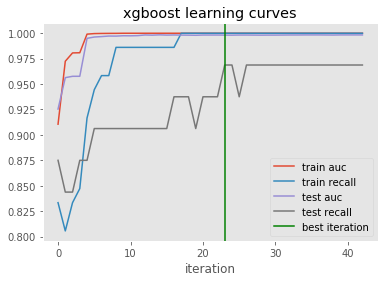

In [28]:

# Let's look at how the metrics changed on the train and test sets as more trees were added

for i in results_dict:
    for err in results_dict[i]:
        plt.plot(results_dict[i][err], label=i+' '+err)   
plt.axvline(xgb_test.best_iteration, c='green', label='best iteration')
plt.xlabel('iteration')
# plt.ylabel(err)
plt.title('xgboost learning curves')
plt.legend()
plt.grid() ;

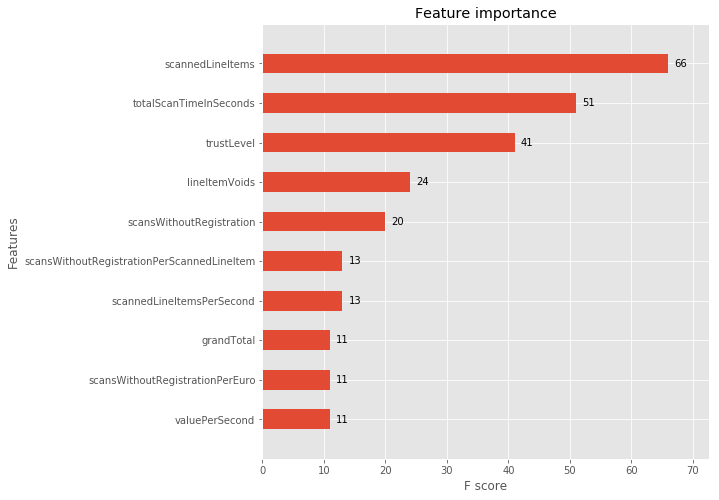

In [29]:
# Plot feature importances

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
xgb.plot_importance(xgb_test, max_num_features=10, height=0.5, ax=ax);

In [30]:

# Generate list of features sorted by importance in detecting fraud
# https://stackoverflow.com/questions/613183/sort-a-python-dictionary-by-value

import operator
x = xgb_test.get_fscore()
sorted_x = sorted(x.items(), key=operator.itemgetter(1), reverse=True)

# print( 'Top eight features for fraud detection: ', [ i[0] for i in sorted_x[:8] ] )

sorted_cols = [i[0] for i in sorted_x] + ['fraud']
print( sorted_cols )


['scannedLineItems', 'totalScanTimeInSeconds', 'trustLevel', 'lineItemVoids', 'scansWithoutRegistration', 'scannedLineItemsPerSecond', 'scansWithoutRegistrationPerScannedLineItem', 'valuePerSecond', 'scansWithoutRegistrationPerEuro', 'grandTotal', 'lineItemVoidsPerPosition', 'quantityModificationsPerSecond', 'scansWithoutRegistrationPerSecond', 'quantityModificationsPerScannedLineItem', 'pricePerScannedLineItem', 'quantityModificationsPerEuro', 'lineItemVoidsPerSecond', 'lineItemVoidsPerEuro', 'fraud']


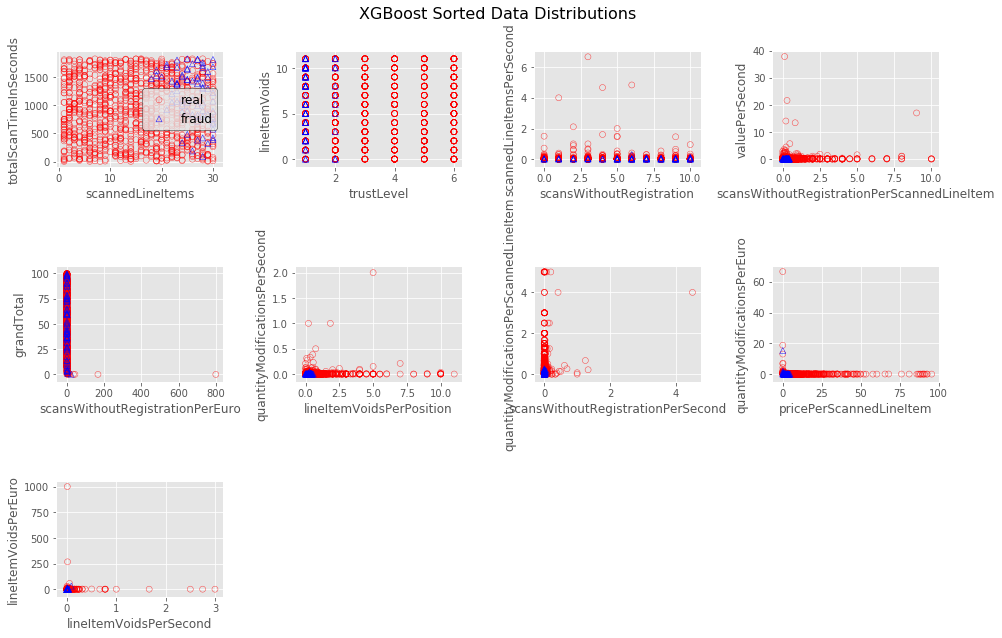

In [31]:

# Plot all of the training data with paired features sorted by importance
# This takes a while

colors = ['red','blue']
markers = ['o','^']
labels = ['real','fraud']
alphas = [0.7, 0.9]

columns = 4
rows = int( np.ceil( len(data_cols) / columns / 2 ) )
plt.figure( figsize=(columns*3.5, rows*3) )
plt.suptitle('XGBoost Sorted Data Distributions ', size=16)

train = train_df.copy()

for i in range( int(np.floor(len(sorted_x)/2)) )[:]:
    col1, col2 = sorted_x[i*2][0], sorted_x[i*2+1][0]
#     print(i,col1,col2)
    
    plt.subplot(rows,columns,i+1)  
    for group, color, marker, label, alpha in zip( train.groupby('fraud'), colors, markers, labels, alphas ):
        plt.scatter( group[1][col1], group[1][col2], 
                         label=label, marker=marker, alpha=alpha,
                         edgecolors=color, facecolors='none' )         
    plt.xlabel(col1, size=12)
    plt.ylabel(col2, size=12)
    plt.tick_params(axis='both', labelsize=10)
    if i == 0: plt.legend(fontsize=12, edgecolor='black')

plt.tight_layout(rect=[0,0,1,0.95]) # xmin, ymin, xmax, ymax
# plt.savefig('plots/XGB_Sorted_Data_Distributions.png')
plt.show()


In [32]:


# Lets look at the effect of the ratio of normal:fraud data in the dataset on recall and roc_auc
# We'll use cross validation to see if differences are significant


np.random.seed(0)

n_real = np.sum(data.fraud==0) # 200000
n_test = np.sum(data.fraud==1) # 492
real_samples = data.loc[ data.fraud==0, test_cols].sample(n_real, replace=False).reset_index(drop=True)
test_samples = data.loc[ data.fraud==1, test_cols].sample(n_test, replace=False).reset_index(drop=True)
X_col = data.columns[:-1]
y_col = data.columns[-1]

test_data=[]

# for i in [1]:
# for i in [0.1,0.5,1,2,10]:
for i in np.logspace(-1,2,8):
    print(i)
    train_df = pd.concat([real_samples[:int(n_test*i)],test_samples[:n_test]],axis=0,ignore_index=True).reset_index(drop=True)
    dtrain = xgb.DMatrix(train_df[X_col], train_df[y_col], feature_names=X_col)
    results = xgb.cv(xgb_params, dtrain, 
                     nfold=5, num_boost_round=100, early_stopping_rounds=10, seed=0,
                     feval=recall)
    test_data.append(list([i]) + list(results.tail(1).index) + list(results.tail(1).values[0]))
    
test_data = pd.DataFrame(test_data, columns=list(['ratio','best'])+list(results.columns))
test_data

0.1


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


XGBoostError: b'[14:55:08] C:\\Users\\Administrator\\Desktop\\xgboost\\src\\metric\\rank_metric.cc:144: Check failed: !auc_error AUC: the dataset only contains pos or neg samples'

In [33]:

# Recall decreases as more normal data is added

# metric = 'auc'
metric = 'recall'
# xs = test_data['ratio'].values
xs = np.log10(test_data['ratio'].values)
ys = test_data['test-'+metric+'-mean'].values
stds = test_data['test-'+metric+'-std'].values
plt.plot(xs,ys,c='C1')
plt.plot(xs,ys+stds,linestyle=':',c='C2')
plt.plot(xs,ys-stds,linestyle=':',c='C2')
plt.xlabel('log10 ratio of normal:fraud data')
plt.ylabel(metric)
# plt.ylim([0.96,1.01])
plt.show()

TypeError: list indices must be integers or slices, not str

<a id="Classification"><h1>Classification</h1></a>

<a href='#TOC'>Table of contents</a>

In [34]:

# load clustering libraries

import sklearn.cluster as cluster


In [48]:
!python -m pip install --upgrade pip --user

  Using cached https://files.pythonhosted.org/packages/f9/fb/863012b13912709c13cf5cfdbfb304fa6c727659d6290438e1a88df9d848/pip-19.1-py2.py3-none-any.whl


twisted 18.7.0 requires PyHamcrest>=1.9.0, which is not installed.
You are using pip version 10.0.1, however version 19.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [49]:
!pip install PyHamcrest

In [ ]:

# hdbscan not in kaggle/python at present

#!conda install -c conda-forge hdbscan
#!pip install hdbscan --no-binary

import hdbscan


In [36]:
!pip install --upgrade git+https://github.com/scikit-learn-contrib/hdbscan.git#egg=hdbscan
import hdbscan    

  Cloning https://github.com/scikit-learn-contrib/hdbscan.git to c:\users\jan-he~2\appdata\local\temp\pip-install-lmn_mz9v\hdbscan
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Using cached https://files.pythonhosted.org/packages/4e/9d/c129d78e6b942303b762ccfdf1f8339de80c5e6021b14ef0c99ec5bdc6aa/numpy-1.16.3-cp37-cp37m-win_amd64.whl
  Running setup.py clean for hdbscan
Failed to build hdbscan


  Running command git clone -q https://github.com/scikit-learn-contrib/hdbscan.git 'C:\Users\JAN-HE~2\AppData\Local\Temp\pip-install-lmn_mz9v\hdbscan'
  ERROR: Complete output from command 'C:\ProgramData\Anaconda3\python.exe' 'C:\Users\Jan-Hendrik Damm\AppData\Roaming\Python\Python37\site-packages\pip\_vendor\pep517\_in_process.py' build_wheel 'C:\Users\JAN-HE~2\AppData\Local\Temp\tmp2f6ubujd':
  ERROR: running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win-amd64-3.7
  creating build\lib.win-amd64-3.7\hdbscan
  copying hdbscan\hdbscan_.py -> build\lib.win-amd64-3.7\hdbscan
  copying hdbscan\plots.py -> build\lib.win-amd64-3.7\hdbscan
  copying hdbscan\prediction.py -> build\lib.win-amd64-3.7\hdbscan
  copying hdbscan\robust_single_linkage_.py -> build\lib.win-amd64-3.7\hdbscan
  copying hdbscan\validity.py -> build\lib.win-amd64-3.7\hdbscan
  copying hdbscan\__init__.py -> build\lib.win-amd64-3.7\hdbscan
  creating build\lib.win-amd64-3.7\hdbs

ModuleNotFoundError: No module named 'hdbscan'

In [40]:

# Set up training set to consist of only fraud data

train = data.loc[ data['fraud']==1 ].copy()

print( pd.DataFrame( [ [np.sum(train['fraud']==i)] for i in np.unique(train['fraud']) ], columns=['count'], index=np.unique(train['fraud']) ) )

# train = pd.get_dummies(train, columns=['Class'], prefix='Class')
label_cols = [ i for i in train.columns if 'fraud' in i ]
data_cols = [ i for i in train.columns if i not in label_cols ]
train_no_label = train[ data_cols ]


     count
1.0    104


In [41]:
%%time

# TSNE is an interesting method to map higher dimensional data into two dimensions
# http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

# Note TSNE map may not be what you might think:
# https://distill.pub/2016/misread-tsne/

# Create multiple projections to compare results from different random states

from sklearn.manifold import TSNE

projections = [ TSNE(random_state=i).fit_transform(train_no_label) for i in range(3) ]


Wall time: 6.41 s


0 KMeans
1 Agglomerative


FileNotFoundError: [Errno 2] No such file or directory: 'plots/Fraud_Cluster_Diagram.png'

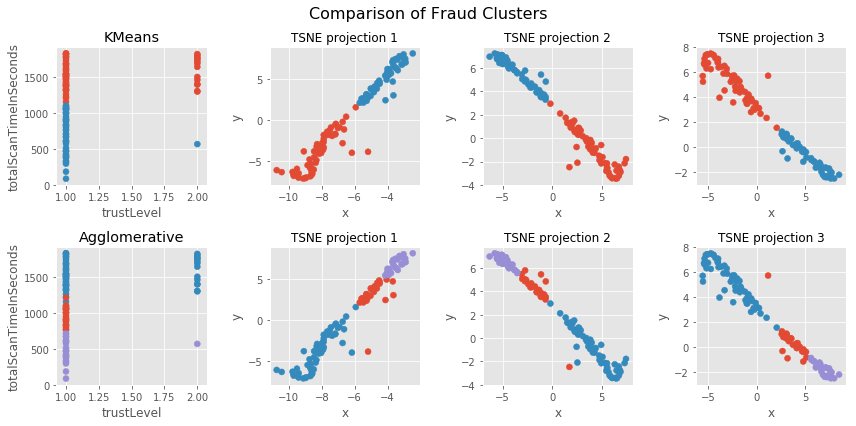

In [42]:
%%time 

# Now we'll compare some different clustering algorithms
# https://github.com/scikit-learn-contrib/hdbscan/blob/master/docs/comparing_clustering_algorithms.rst

algorithms = [ 
#     [ 'KMeans', cluster.KMeans, (), {'random_state':0} ],
    [ 'KMeans', cluster.KMeans, (), {'n_clusters':2, 'random_state':0} ],
#     [ 'KMeans 3', cluster.KMeans, (), {'n_clusters':3, 'random_state':0} ],
#     [ 'Agglomerative', cluster.AgglomerativeClustering, (), {} ],
    [ 'Agglomerative', cluster.AgglomerativeClustering, (), {'linkage': 'ward', 'n_clusters': 3} ],
#     [ 'Agg. Ave 3', cluster.AgglomerativeClustering, (), {'linkage': 'average', 'n_clusters': 3} ],
#     [ 'Agg. Complete 3', cluster.AgglomerativeClustering, (), {'linkage': 'complete', 'n_clusters': 3} ],
#     [ 'DBSCAN', cluster.DBSCAN, (), {'eps':0.025} ],
#     [ 'HDBSCAN', hdbscan.HDBSCAN, (), {} ],
#    [ 'HDBSCAN', hdbscan.HDBSCAN, (), {'min_cluster_size':10, 'min_samples':1, } ],
#     [ 'HDBSCAN 2 10', hdbscan.HDBSCAN, (), {'min_cluster_size':2, 'min_samples':10, } ],
#     [ 'HDBSCAN 10 10 ', hdbscan.HDBSCAN, (), {'min_cluster_size':10, 'min_samples':10, } ],
]

rows = len(algorithms)
columns = 4
plt.figure(figsize=(columns*3, rows*3))

for i, [name, algorithm, args, kwds] in enumerate(algorithms):
    print(i, name)

    labels = algorithm(*args, **kwds).fit_predict(train_no_label)
#     labels = algorithm(*args, **kwds).fit_predict(projections[0])
    
#     print( pd.DataFrame( [ [np.sum(labels==i)] for i in np.unique(labels) ], columns=['count'], index=np.unique(labels) ) )
    
    colors = np.clip(labels,-1,9)
    colors = [ 'C'+str(i) if i>-1 else 'black' for i in colors ]
    
    plt.subplot(rows,columns,i*columns+1)
    plt.scatter(train_no_label[data_cols[0]], train_no_label[data_cols[1]], c=colors)
    plt.xlabel(data_cols[0]), plt.ylabel(data_cols[1])
    plt.title(name)

    for j in range(3):
        plt.subplot(rows,columns,i*columns+1+j+1)
        plt.scatter(*(projections[j].T), c=colors) 
        plt.xlabel('x'), plt.ylabel('y')
        plt.title('TSNE projection '+str(j+1),size=12)
        
#     break

plt.suptitle('Comparison of Fraud Clusters', size=16)
plt.tight_layout(rect=[0,0,1,0.95])
plt.savefig('plots/Fraud_Cluster_Diagram.png')
plt.show()

In [43]:

# Now pick a set of labels and add to the dataset

algorithm = cluster.KMeans
args, kwds = (), {'n_clusters':2, 'random_state':0}
labels = algorithm(*args, **kwds).fit_predict(train_no_label)
# labels = algorithm(*args, **kwds).fit_predict(projections[0])

print( pd.DataFrame( [ [np.sum(labels==i)] for i in np.unique(labels) ], columns=['count'], index=np.unique(labels) ) )

fraud_w_classes = train.copy()
fraud_w_classes['Class'] = labels


   count
0     58
1     46


In [44]:

# Let's see which features are most useful for detecting differences between the classes:

dtrain = xgb.DMatrix(fraud_w_classes[data_cols], fraud_w_classes['Class'], feature_names=data_cols)

xgb_params = {
    'objective': 'binary:logistic',
    'random_state': 0,
    'eval_metric': 'auc', # allows for balanced or unbalanced classes 
    }
xgb_test = xgb.train(xgb_params, dtrain, num_boost_round=10) # limit to ten rounds for fast evaluation

import operator
x = xgb_test.get_fscore()
sorted_x = sorted(x.items(), key=operator.itemgetter(1), reverse=True)
print( 'Top eight features: ', [ [i[0],i[1]] for i in sorted_x[:8] ] )


Top eight features:  [['totalScanTimeInSeconds', 10]]


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


<a id="GAN setup"><h1>GAN setup and training</h1></a>

<a href='#TOC'>Table of contents</a>


Resources:

https://github.com/wayaai/GAN-Sandbox
<br>
http://blog.richardweiss.org/2017/07/21/conditional-wasserstein-gan.html



Conversion of Waya.ai GAN and WGAN
- Remove convolutional layers
- Remove ResNeXt
- Add simple dense networks
- Convert WGAN back to simple GAN
- Use common functions as much as possible



For these functions I've passed the arguments as lists because it was easy to implement.

Standard solutions (because they are more stable) include using keyword dictionaries or objects, but those create a larger code base.


In [ ]:


# reloading the libraries and setting the parameters


import GAN_171103
import importlib
importlib.reload(GAN_171103) # For reloading after making changes
from GAN_171103 import *

rand_dim = 32 # 32 # needs to be ~data_dim
base_n_count = 128 # 128

nb_steps = 500 + 1 # 50000 # Add one for logging of the last interval
batch_size = 128 # 64

k_d = 1  # number of critic network updates per adversarial training step
k_g = 1  # number of generator network updates per adversarial training step
critic_pre_train_steps = 100 # 100  # number of steps to pre-train the critic before starting adversarial training
log_interval = 100 # 100  # interval (in steps) at which to log loss summaries and save plots of image samples to disc
learning_rate = 5e-4 # 5e-5
data_dir = 'cache/'
generator_model_path, discriminator_model_path, loss_pickle_path = None, None, None

# show = False
show = True 

# train = create_toy_spiral_df(1000)
# train = create_toy_df(n=1000,n_dim=2,n_classes=4,seed=0)
train = fraud_w_classes.copy().reset_index(drop=True) # fraud only with labels from classification

# train = pd.get_dummies(train, columns=['Class'], prefix='Class', drop_first=True)
label_cols = [ i for i in train.columns if 'Class' in i ]
data_cols = [ i for i in train.columns if i not in label_cols ]
train[ data_cols ] = train[ data_cols ] / 10 # scale to random noise size, one less thing to learn
train_no_label = train[ data_cols ]

In [ ]:
%%time

# Training the vanilla GAN and CGAN architectures

k_d = 1  # number of critic network updates per adversarial training step
learning_rate = 5e-4 # 5e-5
arguments = [rand_dim, nb_steps, batch_size, 
             k_d, k_g, critic_pre_train_steps, log_interval, learning_rate, base_n_count,
            data_dir, generator_model_path, discriminator_model_path, loss_pickle_path, show ]

adversarial_training_GAN(arguments, train_no_label, data_cols ) # GAN
adversarial_training_GAN(arguments, train, data_cols=data_cols, label_cols=label_cols ) # CGAN

In [ ]:
%%time

# Training the WGAN and WCGAN architectures

k_d = 5 # train critic to optimal state each time
learning_rate = 1e-4 # 5e-5
arguments = [rand_dim, nb_steps, batch_size, 
             k_d, k_g, critic_pre_train_steps, log_interval, learning_rate, base_n_count,
            data_dir, generator_model_path, discriminator_model_path, loss_pickle_path, show ]

adversarial_training_WGAN(arguments, train_no_label, data_cols=data_cols ) # WGAN
adversarial_training_WGAN(arguments, train, data_cols=data_cols, label_cols=label_cols ) # WCGAN

In [ ]:
# %%time

# # for continued training

# import GAN_1711103
# import importlib
# importlib.reload(GAN_171103) # For reloading after making changes
# from GAN_171103 import *

# last_step = 1000
# prefix = 'WGAN'
# # data_dir = 'cache lr mix base 128 act mix 171026/'
# data_dir = 'cache/'

# # Choose your learning rate
# # learning_rate = 1e-5 # first 10k
# # learning_rate = 1e-5 # 10-15k
# # learning_rate = 1e-6 # 15-20k

# generator_model_path = data_dir + prefix + '_generator_model_weights_step_' + str(last_step) + '.h5'
# discriminator_model_path = data_dir + prefix + '_discriminator_model_weights_step_' + str(last_step) + '.h5'
# loss_pickle_path = data_dir + prefix + '_losses_step_' + str(last_step) + '.pkl'

# nb_steps = 4000

# arguments = [rand_dim, nb_steps, batch_size, 
#              k_d, k_g, critic_pre_train_steps, log_interval, learning_rate, base_n_count,
#             data_dir, generator_model_path, discriminator_model_path, loss_pickle_path, show ]

# # Choose your training algorithm
# # adversarial_training_GAN(arguments, train_no_label, data_cols=data_cols, starting_step=last_step+1 ) # GAN
# # adversarial_training_GAN(arguments, train, data_cols=data_cols, label_cols=label_cols, starting_step=last_step+1 ) # CGAN
# # adversarial_training_WGAN(arguments, train_no_label, data_cols=data_cols, starting_step=last_step+1 ) # WGAN
# adversarial_training_WGAN(arguments, train, data_cols=data_cols, label_cols=label_cols, starting_step=last_step+1 ) # WCGAN

In [ ]:

# For reloading loss data from pickles

prefix = 'WCGAN'
step = 500

[combined_loss, disc_loss_generated, disc_loss_real, xgb_losses] = pickle.load(
    open(data_dir+prefix+'_losses_step_'+str(step)+'.pkl','rb'))


In [ ]:
# plt.plot( xgb_losses[:] ) ;
w = 10
plt.plot( pd.DataFrame(xgb_losses[:]).rolling(w).mean() ) ;

In [ ]:

# Look for the step with the lowest xgboost accuracy, and the lowest step saved (every 100)

best_step = list(xgb_losses).index( xgb_losses.min() ) * 10
print( best_step, xgb_losses.min() )

xgb100 = [ xgb_losses[i] for i in range(0, len(xgb_losses), 10) ]
best_step = xgb100.index( min(xgb100) ) * log_interval
print( best_step, min(xgb100) )

In [ ]:

# Look for the step with the lowest critic loss, and the lowest step saved (every 100)

delta_losses = np.array(disc_loss_real) - np.array(disc_loss_generated)

best_step = list(delta_losses).index( delta_losses.min() )
print( best_step, delta_losses.min() )

delta100 = [ delta_losses[i] for i in range(0, len(delta_losses), 100) ]
best_step = delta100.index( min(delta100) ) * log_interval
print( best_step, min(delta100) )

In [ ]:
# plt.plot( (np.array(disc_loss_real) - np.array(disc_loss_generated)) )

w = 50
# plt.plot( list(range(0,5001,1)), pd.rolling_mean((np.array(disc_loss_real) - np.array(disc_loss_generated)),w) )
plt.plot( pd.DataFrame(disc_loss_real[:]).rolling(w).mean() - pd.DataFrame(disc_loss_generated[:]).rolling(w).mean() ) ;

# plt.xlim([9000,10000])
# plt.ylim([0.03,0.05])

In [ ]:
# Let's look at some of the generated data
# First create the networks locally and load the weights

import GAN_171103
import importlib
importlib.reload(GAN_171103) # For reloading after making changes
from GAN_171103 import *

seed = 17

train = fraud_w_classes.copy().reset_index(drop=True) # fraud only with labels from classification

# train = pd.get_dummies(train, columns=['Class'], prefix='Class', drop_first=True)
label_cols = [ i for i in train.columns if 'Class' in i ]
data_cols = [ i for i in train.columns if i not in label_cols ]
train[ data_cols ] = train[ data_cols ] / 10 # scale to random noise size, one less thing to learn
train_no_label = train[ data_cols ]

data_dim = len(data_cols)
label_dim = len(label_cols)
with_class = False
if label_dim > 0: with_class = True
np.random.seed(seed)

# define network models

# generator_model, discriminator_model, combined_model = define_models_CGAN(rand_dim, data_dim, label_dim, base_n_count, type='Wasserstein')
# generator_model.load_weights('cache/WCGAN_generator_model_weights_step_4800.h5')
generator_model, discriminator_model, combined_model = define_models_CGAN(rand_dim, data_dim, label_dim, base_n_count)
generator_model.load_weights('cache/CGAN_generator_model_weights_step_500.h5')


# with_class = False
# train = train_no_label
# label_cols = []
# # generator_model, discriminator_model, combined_model = define_models_GAN(rand_dim, data_dim, base_n_count, type='Wasserstein')
# # generator_model.load_weights('cache/WGAN_generator_model_weights_step_4800.h5')

# generator_model, discriminator_model, combined_model = define_models_GAN(rand_dim, data_dim, base_n_count)
# generator_model.load_weights('cache/GAN_generator_model_weights_step_5000.h5')

In [ ]:

# Now generate some new data

test_size = 492 # Equal to all of the fraud cases

x = get_data_batch(train, test_size, seed=i+j)
z = np.random.normal(size=(test_size, rand_dim))
if with_class:
    labels = x[:,-label_dim:]
    g_z = generator_model.predict([z, labels])
else:
    g_z = generator_model.predict(z)

In [ ]:
# Check using the same functions used during GAN training

print( CheckAccuracy( x, g_z, data_cols, label_cols, seed=0, with_class=with_class, data_dim=data_dim ) )

PlotData( x, g_z, data_cols, label_cols, seed=0, with_class=with_class, data_dim=data_dim )

In [ ]:
# Now we can train and test an xgboost classifier on our generated data

real_samples = pd.DataFrame(x, columns=data_cols+label_cols)
test_samples = pd.DataFrame(g_z, columns=data_cols+label_cols)
real_samples['syn_label'] = 0
test_samples['syn_label'] = 1

training_fraction = 0.5
n_real, n_test = int(len(real_samples)*training_fraction), int(len(test_samples)*training_fraction)
train_df = pd.concat([real_samples[:n_real],test_samples[:n_test]],axis=0)
test_df = pd.concat([real_samples[n_real:],test_samples[n_test:]],axis=0)

# X_col = test_df.columns[:-(label_dim+1)]
X_col = test_df.columns[:-1]
y_col = test_df.columns[-1]
dtrain = xgb.DMatrix(train_df[X_col], train_df[y_col], feature_names=X_col)
dtest = xgb.DMatrix(test_df[X_col], feature_names=X_col)
y_true = test_df['syn_label']

# dtrain = np.vstack( [ x[:int(len(x)/2)], g_z[:int(len(g_z)/2)] ] )
# dlabels = np.hstack( [ np.zeros(int(len(x)/2)), np.ones(int(len(g_z)/2)) ] )
# dtest = np.vstack( [ x[int(len(x)/2):], g_z[int(len(g_z)/2):] ] )

# dtrain = xgb.DMatrix(dtrain, dlabels, feature_names=data_cols+label_cols)
# dtest = xgb.DMatrix(dtest, feature_names=data_cols+label_cols)
# y_true = dlabels

xgb_params = {
    'max_depth': 4,
    'objective': 'binary:logistic',
    'random_state': 0,
    'eval_metric': 'auc', # allows for balanced or unbalanced classes 
}
xgb_test = xgb.train(xgb_params, dtrain, num_boost_round=10)

y_pred = np.round(xgb_test.predict(dtest))

print( '{:.2f}'.format(SimpleAccuracy(y_pred, y_true)) )

In [ ]:

# Let's look at how the discrimnator scored real and generated data, visualized along every feature

y_pred0 = xgb_test.predict(dtest)

for i in range(0,len(X_col)-1, 2):

    f, axarr = plt.subplots(1, 2, figsize=(6,2) )

    axarr[0].scatter( test_df[:n_real][X_col[i]], test_df[:n_real][X_col[i+1]], c=y_pred0[:n_real], cmap='plasma'  )
    axarr[0].set_title('real')
    axarr[0].set_ylabel(X_col[i+1])

    axarr[1].scatter( test_df[n_real:][X_col[i]], test_df[n_real:][X_col[i+1]], c=y_pred0[n_real:], cmap='plasma'  )
    axarr[1].set_title('test')
    axarr[1].set_xlim(axarr[0].get_xlim()), axarr[1].set_ylim(axarr[0].get_ylim())

    for a in axarr:
        a.set_xlabel(X_col[i])

    plt.show()

In [ ]:

# Now we can compare the real and generated data by class, along every feature

colors = ['red','blue']
markers = ['o','^']
labels = ['real','fraud']

class_label = 'Class'

for i in range(0,len(X_col), 2):
    col1, col2 = i, i+1
    if i+1 >= len(X_col): continue
    
    f, axarr = plt.subplots(1, 2, figsize=(6,2) )
    for group, color, marker, label in zip( test_df[:n_real].groupby(class_label), colors, markers, labels ):
        axarr[0].scatter( group[1][X_col[col1]], group[1][X_col[col2]], label=label, c=color, marker=marker, alpha=0.2) 
    axarr[0].legend()
    axarr[0].set_title('real')
    axarr[0].set_ylabel(X_col[col2])

    for group, color, marker, label in zip( test_df[n_real:].groupby(class_label), colors, markers, labels ):
        axarr[1].scatter( group[1][X_col[col1]], group[1][X_col[col2]], label=label, c=color, marker=marker, alpha=0.2) 
    axarr[1].set_xlim(axarr[0].get_xlim()), axarr[1].set_ylim(axarr[0].get_ylim())
    axarr[1].legend()
    axarr[1].set_title('generated') ;

    for a in axarr:
        a.set_xlabel(X_col[col1])

    plt.show()

In [ ]:

# Evaluate performance on validation set

SimpleMetrics(y_pred,y_true)

In [ ]:

# Plot feature importances used for identifying generated data

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
xgb.plot_importance(xgb_test, max_num_features=20, height=0.5, ax=ax);

<a id="Compare GAN Output"><h1>Compare GAN Output</h1></a>

<a href='#TOC'>Table of contents</a>
<br><br>



It may be best to restart the notebook, run the setup section, and then run this section


In [ ]:

# Set up the training dataset

train = fraud_w_classes.copy().reset_index(drop=True) # fraud only with labels from classification

train = pd.get_dummies(train, columns=['Class'], prefix='Class', drop_first=True)
label_cols = [ i for i in train.columns if 'Class' in i ]
data_cols = [ i for i in train.columns if i not in label_cols ]
train[ data_cols ] = train[ data_cols ] / 10 # scale to random noise size, one less thing to learn
train_no_label = train[ data_cols ]

data_dim = len(data_cols)
label_dim = len(label_cols)

In [ ]:
# Generate empty models

rand_dim = 32
base_n_count = 128
model_names = ['GAN','CGAN','WGAN','WCGAN']
with_classes = [False, True, False, True]
type0s = [None, None, 'Wasserstein', 'Wasserstein']

models = {}

for model_name, with_class, type0 in zip(model_names, with_classes, type0s ):

    if with_class:
        generator_model, discriminator_model, combined_model = \
            define_models_CGAN(rand_dim, data_dim, label_dim, base_n_count, type=type0)
    else:
         generator_model, discriminator_model, combined_model = \
            define_models_GAN(rand_dim, data_dim, base_n_count, type=type0)   
    
    models[model_name] = [ model_name, with_class, type0, generator_model ]

In [ ]:

# Setup parameters

seed = 17
test_size = 492 # number of fraud cases

np.random.seed(seed)
z = np.random.normal(size=(test_size, rand_dim))
x = get_data_batch(train, test_size, seed=seed)
real_samples = pd.DataFrame(x, columns=data_cols+label_cols)
labels = x[:,-label_dim:]

# colors = ['C1','C9']
# colors = ['xkcd:plum', 'xkcd:navy']
colors = ['red','blue']
markers = ['o','^']
class_labels = ['Class 1','Class 2']

col1, col2 = 'V17', 'V10'

base_dir = 'cache lr mix base 128 act mix 171026/'


<a id="Fig5"><h1>Figure 5: Comparison of GAN outputs</h1></a><br>
<a href='#TOC'>Table of contents</a>

In [ ]:


# model_steps = [500, 5000]
# model_steps = [ 0, 100, 200, 500, 1000 ]
model_steps = [ 0, 100, 200, 500, 1000, 2000, 5000]
rows = len(model_steps)
columns = 5

axarr = [[]]*len(model_steps)

fig = plt.figure(figsize=(14,rows*3))

for model_step_ix, model_step in enumerate( model_steps ):
    print(model_step)
        
    axarr[model_step_ix] = plt.subplot(rows, columns, model_step_ix*columns + 1)
    
    for group, color, marker, label in zip( real_samples.groupby('Class_1'), colors, markers, class_labels ):
        plt.scatter( group[1][[col1]], group[1][[col2]], 
                         label=label, marker=marker, edgecolors=color, facecolors='none' )
    
    plt.title('Actual Fraud Data')
    plt.ylabel(col2) # Only add y label to left plot
    plt.xlabel(col1)
    xlims, ylims = axarr[model_step_ix].get_xlim(), axarr[model_step_ix].get_ylim()
        
    if model_step_ix == 0: 
        legend = plt.legend()
        legend.get_frame().set_facecolor('white')
    
    for i, model_name in enumerate( model_names[:] ):
        
        [ model_name, with_class, type0, generator_model ] = models[model_name]
        
        generator_model.load_weights( base_dir + model_name + '_generator_model_weights_step_'+str(model_step)+'.h5')

        ax = plt.subplot(rows, columns, model_step_ix*columns + 1 + (i+1) )
        
        if with_class:
            g_z = generator_model.predict([z, labels])
            gen_samples = pd.DataFrame(g_z, columns=data_cols+label_cols)
            for group, color, marker, label in zip( gen_samples.groupby('Class_1'), colors, markers, class_labels ):
                plt.scatter( group[1][[col1]], group[1][[col2]], 
                                 label=label, marker=marker, edgecolors=color, facecolors='none' )
        else:
            g_z = generator_model.predict(z)
            gen_samples = pd.DataFrame(g_z, columns=data_cols)
            plt.scatter( gen_samples[[col1]], gen_samples[[col2]], 
                             label=class_labels[0], marker=markers[0], edgecolors=colors[0], facecolors='none' )
        plt.title(model_name)   
        plt.xlabel(data_cols[0])
        ax.set_xlim(xlims), ax.set_ylim(ylims)


plt.suptitle('Comparison of GAN outputs', size=16)
plt.tight_layout(rect=[0.075,0,1,0.95])

# Adding text labels for traning steps
vpositions = np.array([ i._position.bounds[1] for i in axarr ])
vpositions += ((vpositions[0] - vpositions[1]) * 0.35 )
for model_step_ix, model_step in enumerate( model_steps ):
    fig.text( 0.05, vpositions[model_step_ix], 'training\nstep\n'+str(model_step), ha='center', va='center', size=12)

# plt.savefig('plots/Comparison_of_GAN_outputs.png')

<a id="Generated Data Testing"><h1>Generated Data Testing</h1></a>

<a href='#TOC'>Table of contents</a>

In [ ]:

# Setup xgboost parameters

xgb_params = {
#     'max_depth': 4,
    'objective': 'binary:logistic',
    'random_state': 0,
    'eval_metric': 'auc', # auc, error
#     'tree_method': 'hist'
#     'grow_policy': 'lossguide' # depthwise, lossguide
}

# https://github.com/dmlc/xgboost/blob/master/demo/guide-python/custom_objective.py

from sklearn.metrics import recall_score, precision_score, roc_auc_score

def recall(preds, dtrain):
    labels = dtrain.get_label()
    return 'recall',  recall_score(labels, np.round(preds))

def precision(preds, dtrain):
    labels = dtrain.get_label()
    return 'precision',  precision_score(labels, np.round(preds))

def roc_auc(preds, dtrain):
    labels = dtrain.get_label()
    return 'roc_auc',  roc_auc_score(labels, preds)


In [ ]:

# Define model parameters

seed = 17
np.random.seed(seed)

data_dim = len(data_cols)
label_dim = len(label_cols)

base_dir = 'cache lr mix base 128 act mix 171026/'
rand_dim = 32
base_n_count = 128


In [ ]:

# defined training set parameters

train_fraction = 0.7
X_col = data.columns[:-1]
y_col = data.columns[-1]

folds = 5


In [ ]:

# Function to make cross folds with different amounts of an additional dataset added

def MakeCrossFolds( g_z_df=[] ):

    np.random.seed(0)

    train_real_set, test_real_set = [], []
    train_fraud_set, test_fraud_set = [], []

    real_samples = data.loc[ data.Class==0 ].copy()
    fraud_samples = data.loc[ data.Class==1 ].copy()

#     n_temp_real = 10000 
    n_temp_real = len(real_samples)

    for seed in range(folds):
        np.random.seed(seed)

        fraud_samples = fraud_samples.sample(len(fraud_samples), replace=False).reset_index(drop=True) # shuffle

    #     n_train_fraud = int(len(fraud_samples) * train_fraction)
        n_train_fraud = 100
        train_fraud_samples = fraud_samples[:n_train_fraud].reset_index(drop=True)

    #     test_fraud_samples = fraud_samples[n_train_fraud:].reset_index(drop=True)
        n_test_fraud = 148 # 30% left out
        test_fraud_samples = fraud_samples[-n_test_fraud:].reset_index(drop=True)

        if len(g_z_df)==0: g_z_df = fraud_samples[n_train_fraud:-n_test_fraud] # for adding real data, if no generated
        n_g_z = len(g_z_df)
        train_fraud_samples = train_fraud_samples.append(g_z_df).reset_index(drop=True)

        real_samples = real_samples.sample(len(real_samples), replace=False).reset_index(drop=True) # shuffle
        temp_real_samples = real_samples[:n_temp_real]
        n_train_real = int(len(temp_real_samples) * train_fraction)

        train_real_samples = temp_real_samples[:n_train_real].reset_index(drop=True) # with margin
        test_real_samples = temp_real_samples[n_train_real:].reset_index(drop=True) # with margin

        train_real_set.append( train_real_samples )
        test_real_set.append( test_real_samples )
        train_fraud_set.append( train_fraud_samples )
        test_fraud_set.append( test_fraud_samples )

    print( n_train_fraud )
    for i in [ fraud_samples, g_z_df, train_fraud_samples, test_fraud_samples ]: print( len(i) )
    for i in [ real_samples, train_real_samples, test_real_samples ]: print( len(i) )
    # [ [ len(i) for i in j ] for j in [train_real_set, test_real_set, train_fraud_set, test_fraud_set] ]
    
    return n_train_fraud, train_real_set, test_real_set, train_fraud_set, test_fraud_set


In [ ]:

# function to run an xgboost classifier on different cross-folds with different amounts of data added

def Run_CV_Xgb(n_train_fraud, train_real_set, test_real_set, train_fraud_set, test_fraud_set):

    test_data=[]

    # for i in [1]:
    # for i in [1,2,5,10,20]:
    # for i in np.logspace(0,np.log10(11),num=5):
    # for i in np.logspace(0,np.log10(11),num=3):
    for i in np.logspace(0,np.log10((492-148)/100),num=5):

        print('# additional generated data tested: {}'.format (int(n_train_fraud*(i-1)) ) )
        for k in range(folds):

            train_df = pd.concat( 
                [ train_real_set[k], train_fraud_set[k][:int(n_train_fraud*i)] ],
                 axis=0,ignore_index=True).reset_index(drop=True)

            test_df = pd.concat( 
                [ test_real_set[k], test_fraud_set[k] ],
                axis=0,ignore_index=True).reset_index(drop=True)

            dtrain = xgb.DMatrix(train_df[X_col], train_df[y_col], feature_names=X_col)
            dtest = xgb.DMatrix(test_df[X_col], test_df[y_col], feature_names=X_col)

            results_dict = {}
            xgb_test = xgb.train(xgb_params, dtrain, num_boost_round=100, 
                                 verbose_eval=False, early_stopping_rounds=10, 
                                 evals=[(dtrain,'train'),(dtest,'test')],
                                 evals_result = results_dict )

            y_pred = xgb_test.predict(dtest, ntree_limit=xgb_test.best_iteration+1)
            y_true = test_df['Class'].values
            results = [k, i, xgb_test.best_iteration, recall( y_pred, dtest )[1], precision( y_pred, dtest )[1], roc_auc( y_pred, dtest )[1] ]
    #         print(results)

            test_data.append(results)
    test_data = pd.DataFrame(test_data, columns=['k', 'ratio','best','recall','precision','auc'])
    return test_data


In [ ]:
%%time

# Generate and test data with untrained model

generator_model, discriminator_model, combined_model = define_models_CGAN(rand_dim, data_dim, label_dim, base_n_count, type='Wasserstein')
generator_model.load_weights( base_dir + 'WCGAN_generator_model_weights_step_0.h5')

test_size = 492
x = get_data_batch(fraud_w_classes, test_size, seed=0)
z = np.random.normal(size=(test_size, rand_dim))
labels = x[:,-label_dim:]
g_z = generator_model.predict([z, labels])


# The labels for the generate data will all be 1, as they are supposed to be fraud data
g_z_df = pd.DataFrame( np.hstack( [g_z[:,:len(data_cols)], np.ones((len(g_z),1))] ), columns=data.columns )

n_train_fraud, train_real_set, test_real_set, train_fraud_set, test_fraud_set = MakeCrossFolds(g_z_df)
    
t_0 = Run_CV_Xgb(n_train_fraud, train_real_set, test_real_set, train_fraud_set, test_fraud_set)


In [ ]:
%%time

# Generate and test data with trained model

generator_model, discriminator_model, combined_model = define_models_CGAN(rand_dim, data_dim, label_dim, base_n_count, type='Wasserstein')
generator_model.load_weights( base_dir + 'WCGAN_generator_model_weights_step_4800.h5')

test_size = 492
x = get_data_batch(fraud_w_classes, test_size, seed=0)
z = np.random.normal(size=(test_size, rand_dim))
labels = x[:,-label_dim:]
g_z = generator_model.predict([z, labels])



# The labels for the generate data will all be 1, as they are supposed to be fraud data
g_z_df = pd.DataFrame( np.hstack( [g_z[:,:len(data_cols)], np.ones((len(g_z),1))] ), columns=data.columns )

n_train_fraud, train_real_set, test_real_set, train_fraud_set, test_fraud_set = MakeCrossFolds(g_z_df)
    
t_4800 = Run_CV_Xgb(n_train_fraud, train_real_set, test_real_set, train_fraud_set, test_fraud_set)


In [ ]:
%%time

# Generate and test data with additional real data

n_train_fraud, train_real_set, test_real_set, train_fraud_set, test_fraud_set = MakeCrossFolds()
    
t_real = Run_CV_Xgb(n_train_fraud, train_real_set, test_real_set, train_fraud_set, test_fraud_set)


In [ ]:

# # Save the testing data

# # Run using the WCGAN trained after 0 steps
# pickle.dump( t_0, open('cache/additional untrained generated fraud data test.pkl','wb'))

# # Run using the WCGAN trained after 4800 steps
# pickle.dump( t_4800, open('cache/additional generated fraud data test.pkl','wb'))

# # Run using the real data
# pickle.dump( t_real, open('cache/additional real fraud data test.pkl','wb'))

In [ ]:

# Reload the testing data

t_0 = pickle.load(open('cache/additional untrained generated fraud data test.pkl','rb'))
t_4800 = pickle.load(open('cache/additional generated fraud data test.pkl','rb'))
t_real = pickle.load(open('cache/additional real fraud data test.pkl','rb'))


<a id="Fig8"><h1>Figure 8: Effects of Additional Data on Fraud Detection</h1></a><br>

<a href='#TOC'>Table of contents</a>

In [ ]:

# Plot the testing data

labels = ['WCGAN\ntrained 0 steps','WCGAN\ntrained 4800 steps','Actual Fraud Data']

metric = 'recall'

plt.figure(figsize=(12,3))
for i, [label, test_data] in enumerate(zip(labels, [t_0, t_4800, t_real])):

    xs = [ n_train_fraud * (i[0]-1) for i in test_data.groupby('ratio') ]
    ys = test_data.groupby('ratio')[metric].mean().values
    stds = 2 * test_data.groupby('ratio')[metric].std().values

    plt.subplot(1,3,i+1)
    plt.axhline(ys[0],linestyle='--',color='red')
    plt.plot(xs,ys,c='C1',marker='o')
    plt.plot(xs,ys+stds,linestyle=':',c='C2')
    plt.plot(xs,ys-stds,linestyle=':',c='C2')
    if i==0: plt.ylabel(metric)
    plt.xlabel('# additional data')
    plt.title(label,size=12)
#     plt.xlim([0,11])
#     plt.ylim([0.55,.85])
    plt.ylim([0.6,1.0])

plt.tight_layout(rect=[0,0,1,0.9])
plt.suptitle('Effects of additional data on fraud detection', size=16)
# plt.savefig('plots/Effects of addtional data on fraud detection.png')
plt.show()

<a id="Summary"><h1>Summary of Training Data</h1></a>

<a href='#TOC'>Table of contents</a>
<br><br>


In [ ]:

# Load the saved loss data from each model

# base_dir = 'cache/'
base_dir = 'cache lr mix base 128 act mix 171026/'

suffix = '_step_5000'

GAN_losses = pickle.load(open(base_dir + 'GAN_losses'+suffix+'.pkl','rb'))
# GAN_losses = [combined_loss, disc_loss_real, disc_loss_generated, xgb_losses]

CGAN_losses = pickle.load(open(base_dir + 'CGAN_losses'+suffix+'.pkl','rb'))
WGAN_losses = pickle.load(open(base_dir + 'WGAN_losses'+suffix+'.pkl','rb'))
WCGAN_losses = pickle.load(open(base_dir + 'WCGAN_losses'+suffix+'.pkl','rb'))

In [ ]:

# Find best xgb scores overall and saved (every 100 steps)

data_ix = 3
data_sets = [ GAN_losses[data_ix], CGAN_losses[data_ix], WGAN_losses[data_ix], WCGAN_losses[data_ix]]
labels = [ 'GAN','CGAN','WGAN','WCGAN' ]

for label, data_set in zip( labels, data_sets ):
    best_step = list(data_set).index( np.array(data_set).min() ) * 10
    print( '{: <5} step {: <4}: {:.4f}'.format( label, best_step, np.array(data_set).min() ) )

    xgb100 = [ data_set[i] for i in range(0, len(data_set), 10) ]
    best_step = xgb100.index( min(xgb100) ) * 100
    print( '{: <5} step {: <4}: {:.4f}\n'.format( label, best_step, np.array(xgb100).min() ) )
#     print( best_step, min(xgb100) )

In [ ]:

# Look at the unsmoothed losses

data_fields = ['combined_losses_', 'real_losses_', 'generated_losses_', 'xgb_losses']
sampling_intervals = [ 1, 1, 1, 10 ]
labels = [ 'GAN','CGAN','WGAN','WCGAN' ]
linestyles = ['-', '--', '-.', ':']

for data_ix in range(len(data_fields)):
    data_sets = [ GAN_losses[data_ix], CGAN_losses[data_ix], WGAN_losses[data_ix], WCGAN_losses[data_ix]]

    plt.figure(figsize=(10,5))
    for data, label, linestyle in zip(data_sets, labels, linestyles):
        plt.plot( np.array(range(0,len(data)))*sampling_intervals[data_ix],
                 data,
                 label=label, linestyle=linestyle )

    plt.ylabel(data_fields[data_ix])
    plt.xlabel('training step')
    plt.legend()
    plt.show()


In [ ]:

# Look at the smoothed losses

data_fields = ['combined_losses_', 'real_losses_', 'generated_losses_', 'xgb_losses']
sampling_intervals = [ 1, 1, 1, 10 ]
labels = [ 'GAN','CGAN','WGAN','WCGAN' ]
linestyles = ['-', '--', '-.', ':']

w = 100
for data_ix in range(len(data_fields)):
    data_sets = [ GAN_losses[data_ix], CGAN_losses[data_ix], WGAN_losses[data_ix], WCGAN_losses[data_ix]]

    plt.figure(figsize=(10,5))
    for data, label, linestyle in zip(data_sets, labels, linestyles):
        plt.plot( np.array(range(0,len(data)))*sampling_intervals[data_ix],
                 pd.DataFrame(data).rolling(w).mean(),
                 label=label, linestyle=linestyle )

    plt.ylabel(data_fields[data_ix])
    plt.xlabel('training step')
    plt.legend()
    plt.show()


<a id="Fig6"><h1>Figure 6: Accuracy of Generated Data Detection</h1></a><br>

<a href='#TOC'>Table of contents</a>

In [ ]:

# Create a figure for the smoothed xgboost losses

data_fields = ['combined_losses_', 'real_losses_', 'generated_losses_', 'xgb_losses']
sampling_intervals = [ 1, 1, 1, 10 ]
labels = [ 'GAN','CGAN','WGAN','WCGAN' ]
linestyles = ['-', '--', '-.', ':']

w = 50
data_ix = 3

data_sets = [ GAN_losses[data_ix], CGAN_losses[data_ix], WGAN_losses[data_ix], WCGAN_losses[data_ix]]

plt.figure(figsize=(10,5))
for data, label, linestyle in zip(data_sets, labels, linestyles):
    plt.plot( np.array(range(0,len(data)))*sampling_intervals[data_ix],
             pd.DataFrame(data).rolling(w).mean(),
             label=label, linestyle=linestyle )

plt.ylabel(data_fields[data_ix])
plt.xlabel('training step')
legend = plt.legend() 
legend.get_frame().set_facecolor('white')

plt.title('Accuracy of generated data detection')
plt.ylabel('xgboost accuracy')
plt.tight_layout() ;
# plt.savefig('plots/GAN_accuracy.png')

<a id="Fig7"><h1>Figure 7: Differences in Critic Loss</h1></a><br>

<a href='#TOC'>Table of contents</a>

In [ ]:

# Create a figure for the critic losses for the WGAN and WCGAN

w = 50

data_ix0 = 2
data_ix1 = 1
data_fields = ['combined_losses_', 'real_losses_', 'generated_losses_', 'xgb_losses']

i1, i2 = 2, 3
i2 += 1

labels = [ 'GAN','CGAN','WGAN','WCGAN' ][i1:i2]
data_sets0 = [ GAN_losses[data_ix0], CGAN_losses[data_ix0], WGAN_losses[data_ix0], WCGAN_losses[data_ix0]][i1:i2]
data_sets1 = [ GAN_losses[data_ix1], CGAN_losses[data_ix1], WGAN_losses[data_ix1], WCGAN_losses[data_ix1]][i1:i2]
linestyles = ['-', '--', '-.', ':'][i1:i2]

plt.figure(figsize=(10,5))
for data0, data1, label, linestyle in zip(data_sets0, data_sets1, labels, linestyles):
    plt.plot( range(0,len(data0)), 
             pd.DataFrame( np.array(data0)-np.array(data1) ).rolling(w).mean(),  
             label=label, linestyle=linestyle )
plt.title('Difference between critic loss (EM distance estimate)\non generated samples and real samples')
plt.xlabel('training step')
plt.ylabel('Gen - Real Critic Loss')
legend = plt.legend() 
legend.get_frame().set_facecolor('white')
# plt.savefig('plots/Delta_critic_loss_plot.png')

<a id="DRAGAN"><h1>DRAGAN Training</h1></a>

<a href='#TOC'>Table of contents</a>
<br><br>


This section is less developed, and may contain more errors that average


A number of errors in the wiseodd code?:
- xavier initializer
- calculation of gradient penalties

Resources:
<br>
https://github.com/kodalinaveen3/DRAGAN
<br>
https://github.com/wiseodd/generative-models
<br>
https://github.com/wiseodd/generative-models/blob/master/GAN/improved_wasserstein_gan/wgan_gp_tensorflow.py
<br>
https://github.com/igul222/improved_wgan_training/blob/master/gan_toy.py


In [ ]:
# Load engineered dataset from EDA section
data = pickle.load(open('data/' + 'credicard.engineered.pkl','rb'))

# Put columns in order of importance for xgboost fraud detection, from the xgboost section
sorted_cols = ['V14', 'V4', 'V10', 'V17', 'Time', 'V12', 'V26', 'Amount', 'V21', 'V8', 'V11', 'V7', 'V28', 'V19', 'V3', 'V22', 'V6', 'V20', 'V27', 'V16', 'V13', 'V25', 'V24', 'V18', 'V2', 'V1', 'V5', 'V15', 'V9', 'V23', 'Class']
data = data[ sorted_cols ].copy()

# data columns will be all other columns except class
data_cols = list(data.columns[ data.columns != 'Class' ])
data_dim = len(data_cols)
# label_cols = ['Class']
train = data.loc[ data.Class == 1, data_cols ].copy().reset_index(drop=True)
train[ data_cols ] = train[ data_cols ] / 10

with_class = False
show = True
data_dir = 'cache/'
cache_prefix = 'DRAGAN'
label_cols = []
log_interval = 100

z_dim = 32
X_dim = data_dim


In [ ]:

# Load (and/or reload functions)

import GAN_171103
import importlib
importlib.reload(GAN_171103) # For reloading after making changes
from GAN_171103 import *


In [ ]:

# Start with a clean tensorflow graph every time

tf.reset_default_graph()


In [ ]:

# Define the DRAGAN network

mb_size = 128 # 128 # minibatch size
h_dim = 128 # 128 # hidden layer dim
lambda0 = 10
learning_rate = 1e-4 # 1e-4
global_seed = 0

[ D_solver, disc_cost, D_loss_real, D_loss_fake,
 X, X_p, z,
 G_solver, gen_cost, G_sample ] = \
    define_DRAGAN_network( X_dim=X_dim, h_dim=h_dim, z_dim=z_dim, learning_rate=learning_rate, mb_size=mb_size, seed=global_seed ) ;
    

In [ ]:

# Set the tensorflow session, set seeds, create a saver function, and glance at the length of the operation set for the graph

sess = tf.Session()

np.random.seed(global_seed)
tf.set_random_seed(global_seed)
sess.graph.seed = global_seed

sess.run(tf.global_variables_initializer())

# saver = tf.train.Saver(theta_D + theta_G , max_to_keep=10000) # 20 Mb+ for all, 1.5 Mb for thetas only
saver = tf.train.Saver( max_to_keep=10000 ) # 20 Mb+ for all, 1.5 Mb for thetas only
# saver.save(sess, data_dir + cache_prefix + '_model_step_0' ) 
# saver.save(sess, data_dir + cache_prefix + '-initial_values' ) 
saver.save(sess, data_dir + cache_prefix ) 

combined_loss, disc_loss_generated, disc_loss_real, xgb_losses = [], [], [], []

best_xgb = 0.7

print( len( sess.graph.get_operations() ) )

In [ ]:
%%time

# Now we train the DRAGAN
# We'll xgboost test it at intervals
# We'll also save the graph weights and losses at intervals as well

for it in range(0, 50000+1):
    
    X_mb = get_data_batch(train, mb_size, seed=it)
    X_mb_p = get_perturbed_batch(X_mb) # DRAGAN

    _, D_loss_curr, d_l_r, d_l_g = sess.run(
        [D_solver, disc_cost, D_loss_real, D_loss_fake],
        feed_dict={X: X_mb, X_p: X_mb_p, z: sample_z(mb_size, z_dim)}
    )

    _, G_loss_curr = sess.run(
        [G_solver, gen_cost],
        feed_dict={z: sample_z(mb_size, z_dim)}
    )

    disc_loss_real.append(d_l_r)
    disc_loss_generated.append(d_l_g)
    combined_loss.append(G_loss_curr)
    
    if it % 100 == 0:
        test_size = 492 # The total number of fraud cases
        x = get_data_batch(train, test_size, seed=it)
        g_z = sess.run(G_sample, feed_dict={z: sample_z(test_size, z_dim)})
        xgb_loss = CheckAccuracy( x, g_z, data_cols, label_cols, seed=0, with_class=with_class, data_dim=data_dim )
        xgb_losses.append(xgb_loss)
        if xgb_loss < best_xgb: 
            best_xgb = xgb_loss
            saver.save(sess, data_dir + cache_prefix, global_step=it, write_meta_graph=False )
            
    if it % log_interval == 0:
        print('Iter: {}; D loss: {:.4}; G_loss: {:.4}; xgb_loss: {:.4}'
              .format(it, D_loss_curr, G_loss_curr, xgb_loss))
        if show:
            PlotData( x, g_z, data_cols, label_cols, seed=0, with_class=with_class, data_dim=data_dim ) 
            
        saver.save(sess, data_dir + cache_prefix, global_step=it, write_meta_graph=False )

        pickle.dump([combined_loss, disc_loss_generated, disc_loss_real, xgb_losses], 
                        open( data_dir + cache_prefix + '_losses_step_{}.pkl'.format(it) ,'wb'))
    

In [ ]:
%%time

# for continued training

for it in range(50001, 100001):
    
    X_mb = get_data_batch(train, mb_size, seed=it)
    X_mb_p = get_perturbed_batch(X_mb) # DRAGAN

    _, D_loss_curr, d_l_r, d_l_g = sess.run(
        [D_solver, disc_cost, D_loss_real, D_loss_fake],
        feed_dict={X: X_mb, X_p: X_mb_p, z: sample_z(mb_size, z_dim)}
    )

    _, G_loss_curr = sess.run(
        [G_solver, gen_cost],
        feed_dict={z: sample_z(mb_size, z_dim)}
    )

    disc_loss_real.append(d_l_r)
    disc_loss_generated.append(d_l_g)
    combined_loss.append(G_loss_curr)
    
    if it % 100 == 0:
        test_size = 492 # mb_size
        x = get_data_batch(train, test_size, seed=it)
        g_z = sess.run(G_sample, feed_dict={z: sample_z(test_size, z_dim)})
        xgb_loss = CheckAccuracy( x, g_z, data_cols, label_cols, seed=0, with_class=with_class, data_dim=data_dim )
        xgb_losses.append(xgb_loss)
#         if xgb_loss < best_xgb: best_xgb = xgb_loss
            
    if it % log_interval == 0:
        print('Iter: {}; D loss: {:.4}; G_loss: {:.4}; xgb_loss: {:.4}'
              .format(it, D_loss_curr, G_loss_curr, xgb_loss))
        if show:
            PlotData( x, g_z, data_cols, label_cols, seed=0, with_class=with_class, data_dim=data_dim ) 
            
        saver.save(sess, data_dir + cache_prefix, global_step=it, write_meta_graph=False )

        pickle.dump([combined_loss, disc_loss_generated, disc_loss_real, xgb_losses], 
                        open( data_dir + cache_prefix + '_losses_step_{}.pkl'.format(it) ,'wb'))
    

In [ ]:
# # For checking if you graph operations list has changed while you weren't looking
# print( len( sess.graph.get_operations() ) )

In [ ]:
# # We should be able to import the graph and weights this way, we just need to redefine whatever operation we want to peform

# tf.reset_default_graph()
# sess = tf.Session()
# print( len( sess.graph.get_operations() ) )

# saver = tf.train.import_meta_graph(data_dir + cache_prefix + '.meta')
# print( len( sess.graph.get_operations() ) )

In [ ]:
# Or we can just define the network like we did before and just load the weights
# That way we already have all the operations defined

# So, to load stored graph, with operations defined locally:

tf.reset_default_graph()
sess = tf.Session()
print( len( sess.graph.get_operations() ) )

[ D_solver, disc_cost, D_loss_real, D_loss_fake,
 X, X_p, z,
 G_solver, gen_cost, G_sample ] = \
    define_DRAGAN_network( X_dim=X_dim, h_dim=h_dim, z_dim=z_dim, learning_rate=learning_rate, mb_size=mb_size, seed=global_seed ) ;

sess = tf.Session()

np.random.seed(global_seed)
tf.set_random_seed(global_seed)
sess.graph.seed = global_seed

sess.run(tf.global_variables_initializer())

saver = tf.train.Saver( max_to_keep=10000 ) # 20 Mb+ for all, 1.5 Mb for thetas only

print( len( sess.graph.get_operations() ) )


In [ ]:
# To load saved weights and test

saver.restore(sess, data_dir + cache_prefix + '-45400' )

print( len( sess.graph.get_operations() ) )

g_z = sess.run(G_sample, feed_dict={z: sample_z(test_size, z_dim)})
# g_z


In [ ]:
# %%time

# We can test the generated data using the functions from the 'GAN Data Testing' Section
# You'll need to load the functions from that section for this to work

# The labels for the generate data will all be 1, as they are supposed to be fraud data
g_z_df = pd.DataFrame( np.hstack( [g_z[:,:len(data_cols)], np.ones((len(g_z),1))] ), columns=data.columns )

n_train_fraud, train_real_set, test_real_set, train_fraud_set, test_fraud_set = MakeCrossFolds(g_z_df)
    
t_DRAGAN = Run_CV_Xgb(n_train_fraud, train_real_set, test_real_set, train_fraud_set, test_fraud_set)


In [ ]:
# Looks like still no increase in recall

t_DRAGAN.groupby('ratio')[['recall']].aggregate(['mean','std'])

In [ ]:

# To load saved losses

prefix = 'DRAGAN'

[combined_loss, disc_loss_generated, disc_loss_real, xgb_losses] = pickle.load(open(data_dir+prefix+'_losses_step_100000.pkl','rb'))


In [ ]:

# Let's look at the xgboost losses

w = 1
plt.plot( pd.DataFrame(xgb_losses[:]).rolling(w).mean() ) ;
# plt.savefig('plots/171031_xgb_loss_DRAGAN_lr1e-4_mb128_hdim128.png')

In [ ]:
# Let's look at the smoothed xgboost losses

w = 20
plt.plot( pd.DataFrame(xgb_losses[:]).rolling(w).mean() ) ;
# plt.savefig('plots/171031_xgb_loss_DRAGAN_lr1e-4_mb128_hdim128.png')

In [ ]:

# Let's find the best xgboost loss

best_step = xgb_losses.index( np.array(xgb_losses).min() ) * 100
print( best_step, np.array(xgb_losses).min() )

xgb100 = [ xgb_losses[i] for i in range(0, len(xgb_losses), 1) ]
best_step = xgb100.index( min(xgb100) ) * log_interval
print( best_step, min(xgb100) )

In [ ]:

# Let's look at training losses

# plt.plot( (np.array(disc_loss_real) - np.array(disc_loss_generated)) )

w = 1000
# plt.plot( list(range(0,5001,1)), pd.rolling_mean((np.array(disc_loss_real) - np.array(disc_loss_generated)),w) )
plt.plot( pd.DataFrame(disc_loss_real[:]).rolling(w).mean() - pd.DataFrame(disc_loss_generated[:]).rolling(w).mean() ) ;

# plt.ylim([-0.005,0.015])

# plt.xlim([50000,110000])
# plt.ylim([-0.001,0.002])